<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/raw/master/Chapter05/images/brown-and-red-concrete-building-3075532.jpg
!wget https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/raw/master/Chapter05/images/starry-night-1093721_1280.jpg

--2021-07-27 02:32:29--  https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/raw/master/Chapter05/images/brown-and-red-concrete-building-3075532.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/master/Chapter05/images/brown-and-red-concrete-building-3075532.jpg [following]
--2021-07-27 02:32:30--  https://raw.githubusercontent.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/master/Chapter05/images/brown-and-red-concrete-building-3075532.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [ ]:
def scale_image(image):
    MAX_DIM = 512
    scale = np.max(image.shape)/MAX_DIM
    print(image.shape)
    new_shape = tf.cast(image.shape[:2]/scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    return image

(744, 496, 3)
(800, 1280, 3)


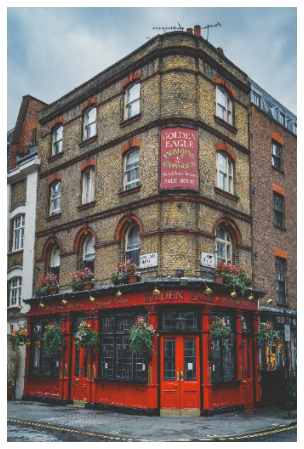

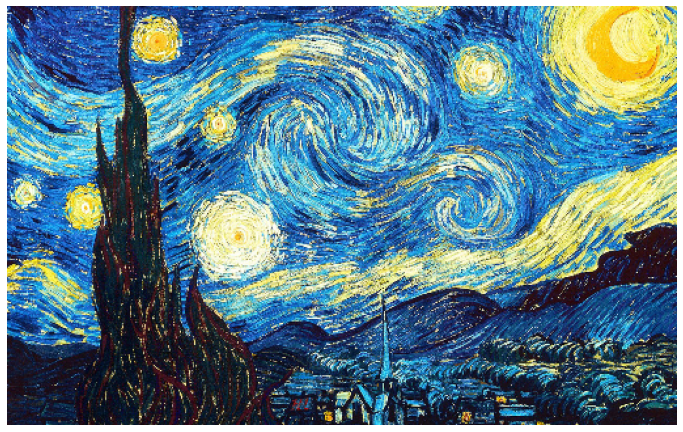

In [ ]:
content_image = scale_image(np.asarray(Image.open('./brown-and-red-concrete-building-3075532.jpg')))
style_image = scale_image(np.asarray(Image.open('./starry-night-1093721_1280.jpg')))
plt.figure(figsize=(10,8))
plt.imshow(content_image/255.)
plt.axis('off')
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(style_image/255.)
plt.axis('off')
plt.show()

In [ ]:
def plot_image(image, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Create a class that will learn to reconstruct a feature vector in a layer of VGG

In [ ]:
class ReconstructImage:
    
    @tf.function
    def extract_features(self, image):
        image = tf.keras.applications.vgg19.preprocess_input(image * 255.)
        content_ref = self.model(image)
        return content_ref

    def calc_loss(self, y_true, y_pred):
        loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            content_features = self.extract_features(self.image)
            loss = self.calc_loss(self.content_ref, content_features)
        grad = tape.gradient(loss, [self.image])
        self.optimizer.apply_gradients(zip(grad, [self.image]))
        self.image.assign(tf.clip_by_value(self.image, 0., 1.))
    
    def get_model(self, layers):
        vgg = tf.keras.applications.VGG19(include_top=False)
        outputs = [vgg.get_layer(x).output for x in layers]
        self.model = Model(vgg.input, outputs)
        self.optimizer = Adam()
    
    def train(self, steps, content_image, content_layers):
        self.get_model(content_layers)

        content_image = tf.reverse(content_image, axis=[-1])
        content_image = tf.cast(tf.expand_dims(content_image, axis=0), tf.float32) / 255.
        self.content_ref = self.extract_features(content_image)
        self.image = tf.Variable(tf.random.normal(shape=content_image.shape), dtype=tf.float32)

        for _ in range(1, steps + 1):
            self.train_step()
        
        plot_image(tf.reverse(self.image, axis=[-1])[0])

Use a deep layer in the network, where much style is gone, and mostly content is remaining

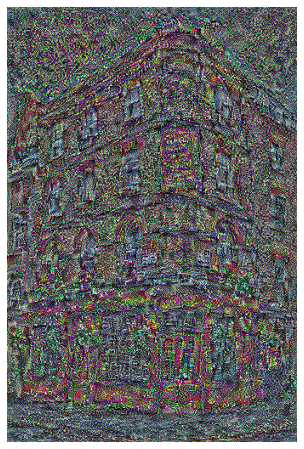

In [ ]:
reconstruct_image = ReconstructImage()
reconstruct_image.train(1000, content_image, ['block5_conv1'])

Try the same thing with a shallower layer in the network, which contains more style

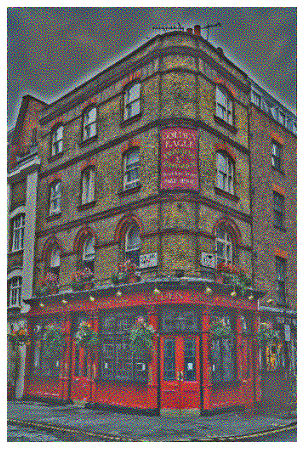

In [ ]:
reconstruct_image = ReconstructImage()
reconstruct_image.train(1000, content_image, ['block2_conv1'])

Now lets try to reconstruct the style of an image

In [ ]:
class ReconstructStyles(ReconstructImage):

    def __init__(self):
        super(ReconstructStyles, self).__init__()

    def gram_matrix(self, x):
        x = tf.transpose(tf.squeeze(x, axis=0), (2, 0, 1))
        x = tf.keras.backend.batch_flatten(x)
        num_points = x.shape[-1]
        gram = tf.linalg.matmul(x, tf.transpose(x)) / num_points
        return gram
    
    
    def extract_features(self, image):
        styles = super(ReconstructStyles, self).extract_features(image)
        styles = self.gram_matrix(styles)
        return styles


    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            style_features = self.extract_features(self.image)
            loss = self.calc_loss(self.style_ref, style_features)
        grad = tape.gradient(loss, [self.image])
        self.optimizer.apply_gradients(zip(grad, [self.image]))
        self.image.assign(tf.clip_by_value(self.image, 0., 1.))
    
    
    def train(self, steps, style_image, style_layers):
        self.get_model(style_layers)

        style_image = tf.reverse(tf.image.resize(style_image, content_image.shape[:2]), axis=[-1])
        style_image = tf.cast(tf.expand_dims(style_image, axis = 0), dtype = tf.float32) / 255.

        self.style_ref = self.extract_features(style_image)

        self.image = tf.Variable(tf.random.normal(shape=style_image.shape), dtype=tf.float32)

        for _ in range(1, steps + 1):
            self.train_step()

        plot_image(tf.reverse(self.image, axis=[-1])[0])

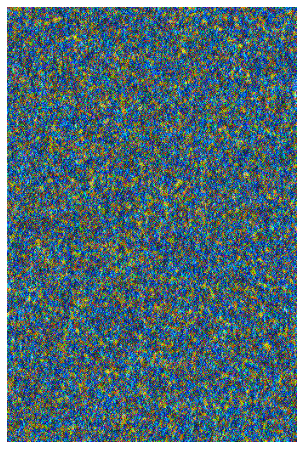

In [ ]:
reconstruct_styles = ReconstructStyles()
reconstruct_styles.train(1000, style_image, ['block1_conv1'])

In [ ]:
class NueralStyleTransfer:

    def __init__(self,
                 content_layers = ['block5_conv1'],
                 style_layers = 
                        ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1', 
                        'block4_conv1', 
                        'block5_conv1']
                 ):
        
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')  

        self.content_outputs = [vgg.get_layer(x).output for x in content_layers]
        self.style_outputs = [vgg.get_layer(x).output for x in style_layers]
        self.model = Model(vgg.input, [self.content_outputs, self.style_outputs])

        self.mse = tf.keras.losses.MeanSquaredError()

    def gram_matrix(self, x):
        x = tf.transpose(tf.squeeze(x, axis=0), (2, 0, 1))
        x = tf.keras.backend.batch_flatten(x)
        num_points = x.shape[-1]
        gram = tf.linalg.matmul(x, tf.transpose(x)) / num_points
        return gram

    def extract_features(self, image):
        image = tf.keras.applications.vgg19.preprocess_input(image * 255.)
        contents, styles = self.model(image)
        styles = [self.gram_matrix(s) for s in styles]
        return contents, styles
    
    def train_step(self):
        with tf.GradientTape() as tape:
            content_features, style_features = self.extract_features(self.image)
            style_loss = self.style_weight * self.loss_fn(self.style_ref, style_features)
            content_loss = self.content_weight * self.loss_fn(self.content_ref, content_features)
            loss = content_loss + style_loss
        
        grad = tape.gradient(loss, self.image)
        self.optimizer.apply_gradients([(grad, self.image)])
        self.image.assign(tf.clip_by_value(self.image, 0., 1.))

        return content_loss, style_loss
    
    def loss_fn(self, y_true, y_pred):
        loss = [self.mse(t, p) for (t, p) in zip(y_true, y_pred)]
        return tf.reduce_mean(loss)
    
    def train(self, steps, content_image, style_image, content_weight=1., style_weight=1e-5):
        self.style_weight = style_weight
        self.content_weight = content_weight
        
        content_image = tf.reverse(content_image, axis=[-1])
        style_image = tf.reverse(tf.image.resize(style_image, content_image.shape[:2]), axis=[-1])
        
        style_image = tf.cast(tf.expand_dims(style_image, 0), tf.float32)/255.
        content_image = tf.cast(tf.expand_dims(content_image, 0), tf.float32)/255.

        self.content_ref, _ = self.extract_features(content_image)
        _, self.style_ref = self.extract_features(style_image)

        self.optimizer = Adam(0.02,  beta_1=0.99, epsilon=1e-1)

        self.image = tf.Variable(content_image)

        for _ in range(steps):
            self.train_step()
        
        plot_image(tf.reverse(self.image, axis=[-1])[0])

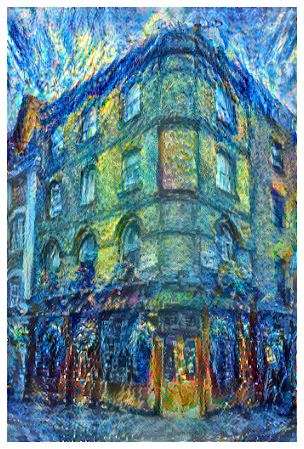

In [ ]:
nst = NueralStyleTransfer()
nst.train(1000, content_image, style_image)